**Overview**
<pre>
The data has been split into two groups:

training set (train.csv)
test set (test.csv)
The training set should be used to build your machine learning models. For the training set, we provide the outcome (also known as the “ground truth”) for each passenger. Your model will be based on “features” like passengers’ gender and class. You can also use feature engineering to create new features.

The test set should be used to see how well your model performs on unseen data. For the test set, we do not provide the ground truth for each passenger. It is your job to predict these outcomes. For each passenger in the test set, use the model you trained to predict whether or not they survived the sinking of the Titanic.

We also include gender_submission.csv, a set of predictions that assume all and only female passengers survive, as an example of what a submission file should look like.

Data Dictionary
Variable	Definition	Key
survival	Survival	0 = No, 1 = Yes
pclass	Ticket class	1 = 1st, 2 = 2nd, 3 = 3rd
sex	Sex	
Age	Age in years	
sibsp	# of siblings / spouses aboard the Titanic	
parch	# of parents / children aboard the Titanic	
ticket	Ticket number	
fare	Passenger fare	
cabin	Cabin number	
embarked	Port of Embarkation	C = Cherbourg, Q = Queenstown, S = Southampton
</pre>

**Variable Notes**
<pre>
pclass: A proxy for socio-economic status (SES)
1st = Upper
2nd = Middle
3rd = Lower

age: Age is fractional if less than 1. If the age is estimated, is it in the form of xx.5

sibsp: The dataset defines family relations in this way...
Sibling = brother, sister, stepbrother, stepsister
Spouse = husband, wife (mistresses and fiancés were ignored)

parch: The dataset defines family relations in this way...
Parent = mother, father
Child = daughter, son, stepdaughter, stepson
Some children travelled only with a nanny, therefore parch=0 for them.
</pre>

In [67]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import norm 
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from scipy.stats import chi2_contingency 
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

pd.options.display.max_columns = None


In [68]:
left = 0.5  # the left side of the subplots of the figure
right = 0.9   # the right side of the subplots of the figure
bottom = 0.4  # the bottom of the subplots of the figure
top = 0.5     # the top of the subplots of the figure
wspace = 0.8  # the amount of width reserved for space between subplots,
              # expressed as a fraction of the average axis width
hspace = 0.8  # the amount of height reserved for space between subplots,
              # expressed as a fraction of the average axis height
    
plt.subplots_adjust(left=left, bottom=bottom, right=right, top=top, wspace=wspace, hspace=hspace)

<Figure size 432x288 with 0 Axes>

In [69]:
ds = pd.read_csv("./data/titanic/train.csv")
ds.set_index('PassengerId', inplace=True)
ds.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [70]:
ds.isnull().sum()

Survived      0
Pclass        0
Name          0
Sex           0
Age         177
SibSp         0
Parch         0
Ticket        0
Fare          0
Cabin       687
Embarked      2
dtype: int64

Cabin feature contains a lot of null values. In addition to it, I feel that this variable does not play much role in prediction.
I don't think Titanic crew asked for people's cabin number before allocating them to a life boat. And same goes with PClass variable

In [71]:
# Drop cabin variable
ds = ds.drop(['Cabin'], axis=1)
# ds = ds.drop(['Pclass'], axis=1)

[]

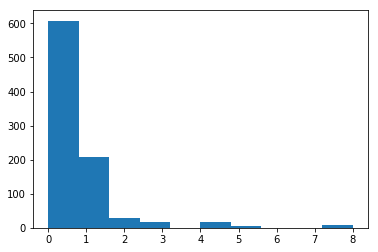

In [72]:
plt.hist(ds.SibSp)
plt.plot()

Seems most of the people were travelling either alone or with there spouse

[]

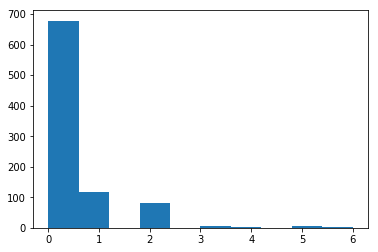

In [73]:
plt.hist(ds.Parch)
plt.plot()

In [74]:
tempds = ds

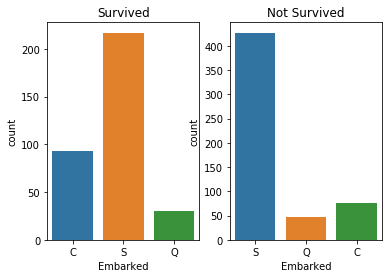

In [75]:
plt.subplot(121)
plt.title("Survived")
sns.countplot(x='Embarked', data=tempds[tempds.Survived==1])
plt.subplot(122)
plt.title("Not Survived")
sns.countplot(x='Embarked', data=tempds[tempds.Survived==0])
plt.show()

Seems People people from all Embarkation have almost equal proportion in Survival and Dying.
Lets do a Chi-Sqaured test to look more into it

In [76]:
def chisqaure_test(df, col1, col2):
    groupSize = df.groupby([col1, col2]).size()
    groupSum = groupSize.unstack(col1)
    #Filling null values to 0 to prevent code to not throw any exceptions
    groupSum = groupSum.fillna(0)
    return chi2_contingency(groupSum)

Assuming significance level as 5%, meaning I am assuming Confidence level of 95% to check if 2 categorical values have any relationship? 

In [77]:
chisqaure_test(tempds, 'Survived', 'Embarked')

(26.48914983923762,
 1.769922284120912e-06,
 2,
 array([[103.7480315,  64.2519685],
        [ 47.5511811,  29.4488189],
        [397.7007874, 246.2992126]]))

Here p-value < significance level, hence I have evidence to proove that there is some relationship between Survived and Embarked

In [78]:
tempds.columns

Index(['Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket',
       'Fare', 'Embarked'],
      dtype='object')

In [79]:
tempds = tempds.dropna(subset=['Embarked'], axis=0)

In [80]:
names = tempds['Name']
tempds = tempds.drop(['Name', 'Ticket'], axis=1)

In [81]:
tempds.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
PassengerId,,,,,,,,
1,0,3,male,22.0,1,0,7.2500,S
2,1,1,female,38.0,1,0,71.2833,C
3,1,3,female,26.0,0,0,7.9250,S
4,1,1,female,35.0,1,0,53.1000,S
5,0,3,male,35.0,0,0,8.0500,S


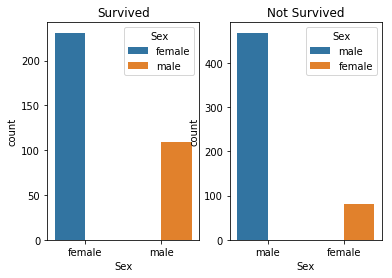

In [82]:
plt.subplot(121)
plt.title("Survived")
sns.countplot(x='Sex', data=tempds[tempds.Survived==1], hue='Sex')
plt.subplot(122)
plt.title("Not Survived")
sns.countplot(x='Sex', data=tempds[tempds.Survived==0], hue='Sex')
plt.show()

Seems that Titanic crew members saved more Women than Men

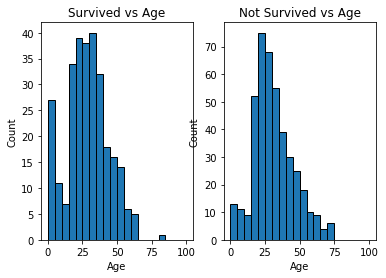

In [83]:
survived_ages = tempds[tempds.Survived == 1]
nsurvived_ages = tempds[tempds.Survived == 0]

plt.subplot(121)
hist, edges = np.histogram(survived_ages.Age, bins=np.arange(0,101,5))
plt.bar(edges[:-1], hist, align="edge", ec="k", width=np.diff(edges))
plt.xlabel("Age")
plt.ylabel("Count")
plt.title("Survived vs Age")

plt.subplot(122)
hist, edges = np.histogram(nsurvived_ages.Age, bins=np.arange(0,101,5))
plt.bar(edges[:-1], hist, align="edge", ec="k", width=np.diff(edges))
plt.xlabel("Age")
plt.ylabel("Count")
plt.title("Not Survived vs Age")

plt.show()

They tried to save as many child (below age 5) as possible 

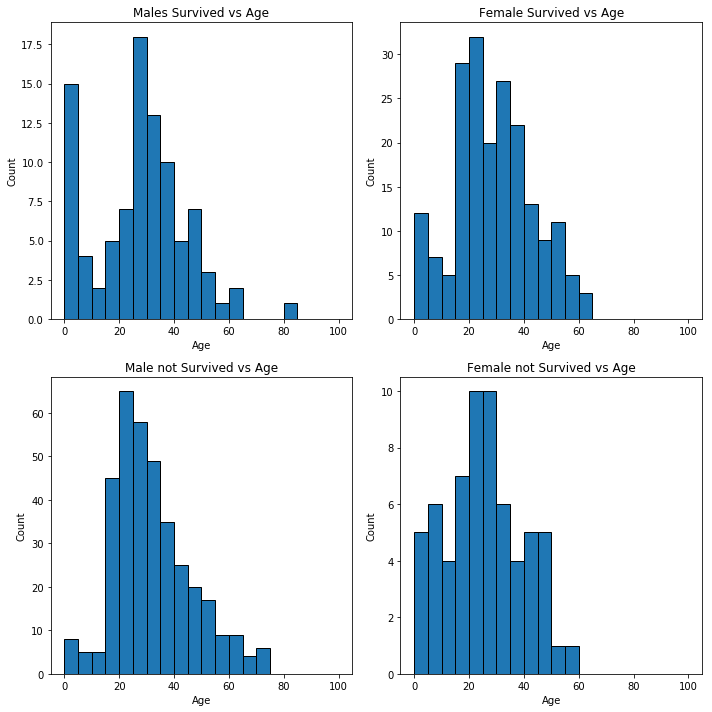

In [84]:
m_surv_age = survived_ages[survived_ages.Sex == 'male']
f_surv_age = survived_ages[survived_ages.Sex == 'female']

m_nsurv_age = nsurvived_ages[nsurvived_ages.Sex == 'male']
f_nsurv_age = nsurvived_ages[nsurvived_ages.Sex == 'female']

fig, axis = plt.subplots(nrows=2, ncols=2)
fig.set_figheight(10)
fig.set_figwidth(10)

plt.subplot(221)
hist, edges = np.histogram(m_surv_age.Age, bins=np.arange(0,101,5))
plt.bar(edges[:-1], hist, align="edge", ec="k", width=np.diff(edges))
plt.xlabel("Age")
plt.ylabel("Count")
plt.title("Males Survived vs Age")

plt.subplot(222)
hist, edges = np.histogram(f_surv_age.Age, bins=np.arange(0,101,5))
plt.bar(edges[:-1], hist, align="edge", ec="k", width=np.diff(edges))
plt.xlabel("Age")
plt.ylabel("Count")
plt.title("Female Survived vs Age")

plt.subplot(223)
hist, edges = np.histogram(m_nsurv_age.Age, bins=np.arange(0,101,5))
plt.bar(edges[:-1], hist, align="edge", ec="k", width=np.diff(edges))
plt.xlabel("Age")
plt.ylabel("Count")
plt.title("Male not Survived vs Age")

plt.subplot(224)
hist, edges = np.histogram(f_nsurv_age.Age, bins=np.arange(0,101,5))
plt.bar(edges[:-1], hist, align="edge", ec="k", width=np.diff(edges))
plt.xlabel("Age")
plt.ylabel("Count")
plt.title("Female not Survived vs Age")

fig.tight_layout()

plt.show()

Graph suggests that most new born male babies were the priority over teenage or men in their 20s and 30s 

Hypothesis -> Instead of just Male and Female, let's introduce one more feature called child. Child will include people with age less than 15

In [85]:
tempds.head(1)

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
PassengerId,,,,,,,,
1,0,3,male,22.0,1,0,7.25,S


In [89]:
def createGender(row):
    val = row[2]
    if (row[3] <= 16):
        val = 'child'
    return val

In [90]:
tempds['Gender'] = tempds.apply(createGender, axis=1)
tempds['Gender'] = pd.Categorical(tempds['Gender'])
dummy_df = pd.get_dummies(tempds['Gender'], prefix='category')
tempds = pd.concat([tempds, dummy_df], axis=1)
dropped_cols = tempds[['Gender', 'Age', 'Sex']]
tempds = tempds.drop(['Gender', 'Age', 'Sex'], axis=1)

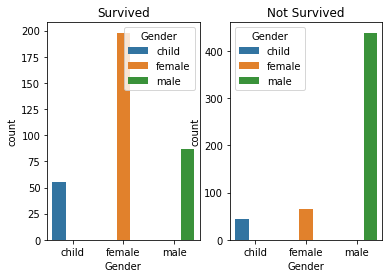

In [41]:
plt.subplot(121)
plt.title("Survived")
sns.countplot(x='Gender', data=tempds[tempds.Survived==1], hue='Gender')
plt.subplot(122)
plt.title("Not Survived")
sns.countplot(x='Gender', data=tempds[tempds.Survived==0], hue='Gender')
plt.show()

Females are the clear winner, but next winner is Child and not the Males

In [91]:
tempds.head(10)

,Survived,Pclass,SibSp,Parch,Fare,Embarked,category_child,category_female,category_male
PassengerId,,,,,,,,,
1,0,3,1,0,7.2500,S,0,0,1
2,1,1,1,0,71.2833,C,0,1,0
3,1,3,0,0,7.9250,S,0,1,0
4,1,1,1,0,53.1000,S,0,1,0
5,0,3,0,0,8.0500,S,0,0,1
6,0,3,0,0,8.4583,Q,0,0,1
7,0,1,0,0,51.8625,S,0,0,1
8,0,3,3,1,21.0750,S,1,0,0
9,1,3,0,2,11.1333,S,0,1,0


/home/krazy/.local/lib/python3.6/site-packages/seaborn/categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/home/krazy/.local/lib/python3.6/site-packages/seaborn/categorical.py:3672: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


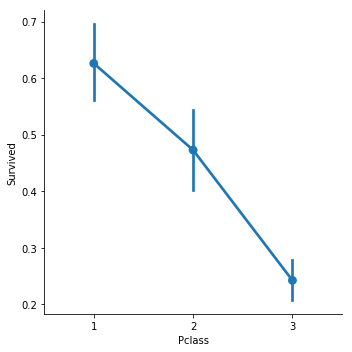

In [104]:
sns.factorplot('Pclass','Survived',order=[1,2,3], data=tempds, size=5)
plt.show()

In [108]:
tempds.columns

Index(['Survived', 'Pclass', 'SibSp', 'Parch', 'Fare', 'Embarked',
       'category_child', 'category_female', 'category_male'],
      dtype='object')

In [109]:
tempds.corr()

,Survived,Pclass,SibSp,Parch,Fare,category_child,category_female,category_male
Survived,1.000000,-0.335549,-0.034040,0.083151,0.255290,0.122737,0.494012,-0.537627
Pclass,-0.335549,1.000000,0.081656,0.016824,-0.548193,0.127349,-0.168237,0.074358
SibSp,-0.034040,0.081656,1.000000,0.414542,0.160887,0.337527,0.044996,-0.258753
Parch,0.083151,0.016824,0.414542,1.000000,0.217532,0.334481,0.147984,-0.352427
Fare,0.255290,-0.548193,0.160887,0.217532,1.000000,-0.003640,0.187210,-0.171499
category_child,0.122737,0.127349,0.337527,0.334481,-0.003640,1.000000,-0.230756,-0.428550
category_female,0.494012,-0.168237,0.044996,0.147984,0.187210,-0.230756,1.000000,-0.780244
category_male,-0.537627,0.074358,-0.258753,-0.352427,-0.171499,-0.428550,-0.780244,1.000000


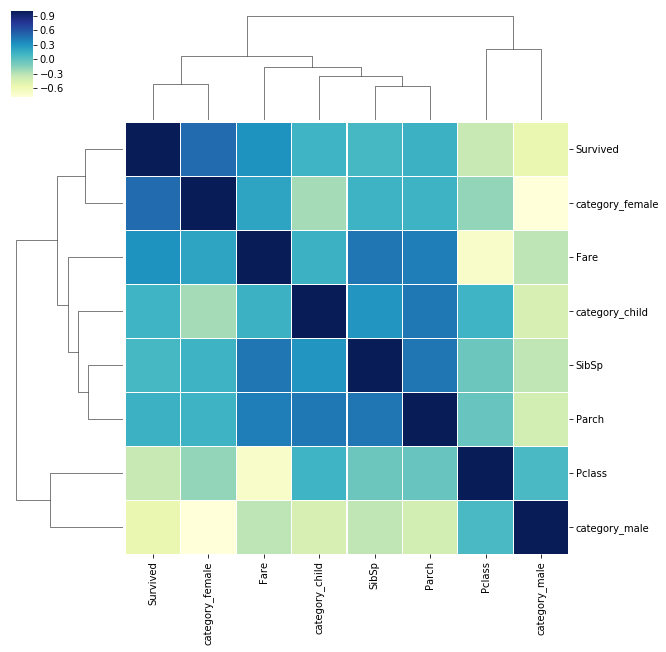

In [110]:
corrmat = tempds.corr(method='spearman')
cg = sns.clustermap(corrmat, cmap="YlGnBu", linewidths=0.1);
plt.setp(cg.ax_heatmap.yaxis.get_majorticklabels(), rotation=0)
cg

In [114]:
# One hot encoding the Embarked variable
embarked = tempds.loc[:,'Embarked']
embarked.head()

PassengerId
1    S
2    C
3    S
4    S
5    S
Name: Embarked, dtype: object

In [95]:
tempds['Embarked'] = pd.Categorical(tempds['Embarked'])

In [115]:
#Convert to dummies
dummy_df = pd.get_dummies(tempds['Embarked'], prefix='category')
dropped_cols = pd.concat([dropped_cols, tempds[['Embarked']]])
tempds = tempds.drop(['Embarked'], axis=1)
tempds = pd.concat([tempds, dummy_df], axis=1)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  This is separate from the ipykernel package so we can avoid doing imports until


**People travelling with family has slighly more chance of survival.**

In [158]:
tempds['Family'] = tempds.SibSp + tempds.Parch
tempds['Family'].loc[tempds.Family > 0] = 1
tempds['Family'].loc[tempds.Family == 0] = 0

/home/krazy/.local/lib/python3.6/site-packages/pandas/core/indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [161]:
tempds = tempds.drop(['SibSp', 'Parch'], axis=1)

## Validating Model

In [163]:
tempds.columns

Index(['Survived', 'Pclass', 'Fare', 'category_child', 'category_female',
       'category_male', 'category_C', 'category_Q', 'category_S', 'Family'],
      dtype='object')

In [ ]:
tempds['Age'] = 

In [164]:
X = tempds[['Pclass', 'Family', 'Fare', 'category_child',
       'category_female', 'category_male', 'category_C', 'category_Q',
       'category_S']]
y = tempds[['Survived']]

In [165]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [166]:
X_train1 = X_train
X_test1 = X_test

In [167]:
y_train = y_train.values.ravel()
y_test = y_test.values.ravel()
y = y.values.ravel()

In [180]:
X_train.head()

,Pclass,Family,Fare,category_child,category_female,category_male,category_C,category_Q,category_S
PassengerId,,,,,,,,,
59,2,1,27.7500,1,0,0,0,0,1
455,3,0,8.0500,0,0,1,0,0,1
456,3,0,7.8958,0,0,1,1,0,0
730,3,1,7.9250,0,1,0,0,0,1
2,1,1,71.2833,0,1,0,1,0,0


In [168]:
X_train.isna().sum()

Pclass             0
Family             0
Fare               0
category_child     0
category_female    0
category_male      0
category_C         0
category_Q         0
category_S         0
dtype: int64

In [169]:
# Headers for classifiers
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score

In [170]:
MNBClassifier = MultinomialNB()
MNBClassifier.fit(X_train1, y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [171]:
y_predict = MNBClassifier.predict(X_test1)
accuracy_score(y_predict, y_test)

0.6797752808988764

In [172]:
from sklearn.naive_bayes import GaussianNB
GNBClassifier = GaussianNB()
GNBClassifier.fit(X_train1, y_train)
y_predict1 = GNBClassifier.predict(X_test1)
accuracy_score(y_predict1, y_test)

0.6966292134831461

In [173]:
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score

In [174]:
# xgb = XGBClassifier(learning_rate=0.5, n_estimators=1000)
xgb = XGBClassifier()

In [175]:
xgb.fit(X_train, y_train)
y_predict1 = xgb.predict(X_test)
accuracy_score(y_predict1, y_test)

0.7865168539325843

In [176]:
# Cross validation
cross_validation(xgb, X, y, 10)

[0.7752809  0.84269663 0.7752809  0.87640449 0.87640449 0.83146067
 0.82022472 0.74157303 0.82022472 0.81818182]
Accuracy: 0.82 (+/- 0.08)


In [177]:
def cross_validation(classifier, X, y, cv=10):
    scores = cross_val_score(classifier, X, y, cv=10)
    print(scores)
    print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

In [178]:
from sklearn import svm
svm = svm.SVC(gamma='scale')
svm.fit(X_train, y_train)
y_predict = svm.predict(X_test)
print(accuracy_score(y_predict, y_test))

0.6123595505617978


In [179]:
cross_validation(svm, X, y)

[0.60674157 0.59550562 0.68539326 0.74157303 0.66292135 0.68539326
 0.68539326 0.68539326 0.69662921 0.65909091]
Accuracy: 0.67 (+/- 0.08)


# Improvements after 1st submission - 0.7897

In [135]:
import re

### Family name engineering

In [136]:
ds['FName'] = ds['Name'].apply(lambda x: (re.findall('[a-zA-Z]+,', x))[0][0:-1])

In [137]:
tt = ds.groupby(['FName']).agg(['count', 'sum'])['Survived']
tt.columns =['total_members', 'total_survived']
tt.head(10)

,total_members,total_survived
FName,,
Abbing,1,0
Abbott,2,1
Abelson,2,1
Adahl,1,0
Adams,1,0
Ahlin,1,0
Aks,1,1
Albimona,1,1
Alexander,1,0


In [ ]:
# Families from whom all lived - Does not help in making any Rule
fnames = (tt[(tt['total_members'] == tt['total_survived']) & (tt['total_members'] > 1)]).index
#ds[ds['FName'].isin(fnames)]

In [138]:
# New born children
ds[ds['Age'] < 1]

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,FName
PassengerId,,,,,,,,,,,
79,1,2,"Caldwell, Master. Alden Gates",male,0.83,0,2,248738,29.0000,S,Caldwell
306,1,1,"Allison, Master. Hudson Trevor",male,0.92,1,2,113781,151.5500,S,Allison
470,1,3,"Baclini, Miss. Helene Barbara",female,0.75,2,1,2666,19.2583,C,Baclini
645,1,3,"Baclini, Miss. Eugenie",female,0.75,2,1,2666,19.2583,C,Baclini
756,1,2,"Hamalainen, Master. Viljo",male,0.67,1,1,250649,14.5000,S,Hamalainen
804,1,3,"Thomas, Master. Assad Alexander",male,0.42,0,1,2625,8.5167,C,Thomas
832,1,2,"Richards, Master. George Sibley",male,0.83,1,1,29106,18.7500,S,Richards


**Rule 1 -> All new born childs are alive. Nice Rule for prediction**

In [148]:
temptt = ds[(ds['SibSp']>=3) & (ds['Parch']>=1)]
len(temptt[temptt.Survived == 0])/len(temptt)

0.8863636363636364

In [154]:
X.head()

,Pclass,Sex,Age,SibSp,Parch,category_C,category_Q,category_S
PassengerId,,,,,,,,
1,3,1,22.0,1,0,0,0,1
2,1,0,38.0,1,0,1,0,0
3,3,0,26.0,0,0,0,0,1
4,1,0,35.0,1,0,0,0,1
5,3,1,35.0,0,0,0,0,1


In [156]:
sns.factorplot('Pclass','Survived',order=[1,2,3], data=X, size=5)

/home/krazy/.local/lib/python3.6/site-packages/seaborn/categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/home/krazy/.local/lib/python3.6/site-packages/seaborn/categorical.py:3672: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


ValueError: Could not interpret input 'Survived'

# For Kaggle Submission

In [ ]:
testds = pd.read_csv("./data/titanic/test.csv")
testds.set_index('PassengerId', inplace=True)
testds.head()

In [ ]:
testds.shape

In [ ]:
# Drop cabin, class variable
testds = testds.drop(['Cabin'], axis=1)
testds = testds.drop(['Pclass'], axis=1)

#testds = testds.dropna(subset=['Embarked'], axis=0)

names = testds['Name']
testds = testds.drop(['Name', 'Ticket'], axis=1)

In [ ]:
# One hot encoding the Embarked variable
embarked = X.iloc[:,-1]
embarked.head()

testds['Embarked_n'] = pd.Categorical(testds['Embarked'])
#Convert to dummies
dummy_df = pd.get_dummies(testds['Embarked_n'], prefix='category')
dummy_df.head()

testds = testds.drop(['Embarked_n'], axis=1)
testds = testds.drop(['Embarked'], axis=1)

testds = pd.concat([testds, dummy_df], axis=1)
testds.head()

In [ ]:
testds.iloc[:,0] = gender_encoder.fit_transform(testds.iloc[:,0])

In [ ]:
testds.isna().sum()

In [ ]:
# No need to fill for XG Boost algo
# testds.fillna(testds.mean(), inplace=True)

In [ ]:
testds.dtypes

In [ ]:
temp_testds = testds

In [ ]:
# No need to drop in case of XGBoost
# testds = testds.drop(['Age'], axis=1)

In [ ]:
testds.columns

In [ ]:
#Prediction with Multinomial NB
y_predict = xgb.predict(testds)

In [ ]:
result = pd.DataFrame(data={'PassengerId': testds.index, 'Survived': y_predict})
result = result.set_index('PassengerId')
result.to_csv('data/titanic/output.csv')

In [ ]:
rule1_survived = temp_testds[temp_testds.Age < 1].index.values

In [ ]:
rule1_survived

In [ ]:
result.loc[rule1_survived]

In [ ]:
y_predict

In [ ]:
# Current score is 0.78947
# current_benchmark = y_predict

In [ ]:
accuracy_score(current_benchmark, y_predict)